# Case study
## Task
Predict income and expenses for a holdout sample of ~10K users for the month of August based on a training sample of ~10K users from Februrary through July.

Based on your judgement of the usefulness of the results, either aggregate the data into incoming & outgoing flows, or predict based on the transaction type/category.


In [28]:
# library
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from sklearn.neural_network import MLPClassifier
import joblib
import os

# custom modules
from LRmodel import LogisticRegressionModels
import plotter
from preprocessing import load_and_preprocess


### Loading the dataset

In [29]:
'''
data
'''
# data_train = pd.read_csv('./data/2016-09-19_79351_training.csv')
data_train = pd.read_csv("./data/2016-09-19_79351_training.csv")
data_mcc_group = pd.read_csv('./data/mcc_group_definition.csv')
data_transaction = pd.read_csv('./data/transaction_types.csv')


# Data wrangling

In [30]:
data_train_main = data_train.copy()

In [31]:
data_train_main.head()

,user_id,transaction_date,transaction_type,mcc_group,amount_n26_currency,dataset_transaction,dataset_user
0,a78884f5e76951188c1e719d4956773a,2016-02-01,DT,NaN,350,training,training
1,b0333294fef6ff1299102a70ad46b126,2016-02-01,DT,NaN,202,training,training
2,7b8d2a2780adae0cd0c248e92c1b28dc,2016-02-01,DT,NaN,291,training,training
3,cc4abaa500f7db4390ae3f02bd36d805,2016-02-01,DT,NaN,214,training,training
4,49b99d1d5ba028566639e8b3eb7c055b,2016-02-01,DT,NaN,272,training,training


In [32]:
data_train_main.dataset_transaction.unique(), data_train_main.dataset_user.unique()

(array(['training'], dtype=object), array(['training'], dtype=object))

In [33]:
data_train_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 408546 entries, 0 to 408545
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   user_id              408546 non-null  object 
 1   transaction_date     408546 non-null  object 
 2   transaction_type     408546 non-null  object 
 3   mcc_group            258324 non-null  float64
 4   amount_n26_currency  408546 non-null  int64  
 5   dataset_transaction  408546 non-null  object 
 6   dataset_user         408546 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 21.8+ MB


The features `dataset_transaction` and  `dataset_user` contains only one unique entry which are irrelevant. We simply drop them. 

In [34]:
data_train_main = data_train_main.drop(['dataset_transaction', 'dataset_user'], axis=1)

In [35]:
data_train_main.head(2)

,user_id,transaction_date,transaction_type,mcc_group,amount_n26_currency
0,a78884f5e76951188c1e719d4956773a,2016-02-01,DT,NaN,350
1,b0333294fef6ff1299102a70ad46b126,2016-02-01,DT,NaN,202


In [36]:
# check for missing values
data_train_main.isna().sum()    

user_id                     0
transaction_date            0
transaction_type            0
mcc_group              150222
amount_n26_currency         0
dtype: int64

In [37]:
# count rows with missing values %
data_train_main.isna().sum()[data_train_main.isna().sum() > 0][0] / len(data_train_main) * 100

36.76991085459165

## To do
 - create ```direction``` (i.e. in/out) feature: the ```in``` and ```out``` represents the income and expenses, respectively. ```in``` denotes money coming into the user acccount and ```out``` denotes money going out of the user account.

 - creating month/day feature from the transaction date.

 - fill NAs in ```mcc_group``` with mode and miscellaneous. We will fill the NAs locally per user. Specifically, we will take the ```mcc_group``` of a user and check for the most frequent transaction type and use this mode to replace any NA for such user. In the event there is no mode, we will simply categorize this as miscellaneous (i.e. 16) since no modal value.

In [38]:
'''
filtered data_transaction based in transaction_type
'''

# filtering data_transaction.type

# data_train_main.user_id.nunique()
selected_types = list(data_train_main.transaction_type.unique()); selected_types
data_transaction_filtered = data_transaction[data_transaction.type.isin(selected_types)]

data_transaction_filtered.reset_index(drop = True, inplace = True); data_transaction_filtered

,type,explanation,direction,agent
0,BBU,Cash26 deposit,In,Partner
1,CT,Credit Transfer,In,Bank Account
2,DR,Debit Reversal,In,Bank Account
3,BUB,Cash26 withdrawal,Out,Partner
4,DD,Direct Debit,Out,Bank Account
5,DT,Debit Transfer,Out,Bank Account
6,FT,MoneyBeam Transfer,Out,Bank Account
7,PT,Presentment,Out,Card
8,TUB,Transferwise Transaction,Out,Partner


In [39]:
# Grouping the transaction type into in and out
type_in = data_transaction_filtered[data_transaction_filtered.direction == 'In'].type
type_out = data_transaction_filtered[data_transaction_filtered.direction == 'Out'].type
type_in, type_out = list(type_in), list(type_out); 
type_in, type_out

(['BBU', 'CT', 'DR'], ['BUB', 'DD', 'DT', 'FT', 'PT', 'TUB'])

In [40]:
## adding in/out feature to data_train_main

data_train_main['direction'] = data_train_main.transaction_type.apply(lambda x: 'In' if x in type_in else 'Out')

In [41]:
# mapping and adding agent feature to data_train_main

type_to_agent = {
    'BBU': 'Partner',
    'CT': 'Bank Account',
    'DR': 'Bank Account',
    'PF': 'Card',
    'PT': 'Card',
    'BUB': 'Partner',
    'DD': 'Bank Account',
    'DT': 'Bank Account',
    'FT': 'Bank Account',
    'TUB': 'Partner'
}

data_train_main['agent'] = data_train_main.transaction_type.apply(lambda x: type_to_agent[x])

In [42]:
# A quick check on the data_train_main
data_train_main[data_train_main.transaction_type == 'PT']

,user_id,transaction_date,transaction_type,mcc_group,amount_n26_currency,direction,agent
526,bf84257bf1b24c4cd05bae3f5ab14b0f,2016-02-01,PT,4.0,15,Out,Card
528,86c37c519ed3516d079fc687c9357eb9,2016-02-01,PT,7.0,4,Out,Card
531,9fed9cf27088374646d08b2356783c25,2016-02-01,PT,2.0,6,Out,Card
532,9fed9cf27088374646d08b2356783c25,2016-02-01,PT,2.0,4,Out,Card
535,2d907dc31f7432c76d3700f9044fa562,2016-02-01,PT,8.0,17,Out,Card
...,...,...,...,...,...,...,...
408407,b18146b3ddb67fcf0b5b9029f217daa2,2016-07-31,PT,2.0,19,Out,Card
408408,e00e269b28ca0b3df5bcdacbeef586d4,2016-07-31,PT,1.0,13,Out,Card
408409,41470ebbb4b34601b1e14615005c6752,2016-07-31,PT,1.0,20,Out,Card
408410,d0f9d173fc2cbf14092ab878609c233d,2016-07-31,PT,6.0,72,Out,Card


=====================================

In [43]:
# extract day/month from data_train_main.transaction_date
data_train_main['transaction_date'] = pd.to_datetime(data_train_main.transaction_date)
data_train_main['day'] = data_train_main.transaction_date.dt.day
data_train_main['month'] = data_train_main.transaction_date.dt.month

### Filling in the missing values in mcc_group feature

=====================================

![title](./img/na_fill.png)


As shown above, we filled the NAs locally per user. Specifically, we take the ```mcc_group``` of a user and check for the most frequent transaction type and use this mode to replace any NA for such user. In the event there is no mode, we simply categorize this as miscellaneous (i.e. 16) since no modal value.

In [44]:
# Function to fill missing values with mode or miscellaneous
def fill_missing_with_mode(df, group_col, target_col):
    
    def mode_function(x):
        modes = x.mode()
        if not modes.empty:
            return modes[0]
        else:
            return 16 #miscellaneous
    
    df[target_col] = df.groupby(group_col)[target_col].transform(lambda x: x.fillna(mode_function(x)))
    
    return df


data_train_main_filled = fill_missing_with_mode(data_train_main, 'user_id', 'mcc_group')


In [45]:
# Testing the result for a user
[data_train_main_filled['user_id']=='001f9baedaf3c8487c344d25b0eda9fc']

[0         False
 1         False
 2         False
 3         False
 4         False
           ...  
 408541    False
 408542    False
 408543    False
 408544    False
 408545    False
 Name: user_id, Length: 408546, dtype: bool]

<Axes: xlabel='mcc_group'>

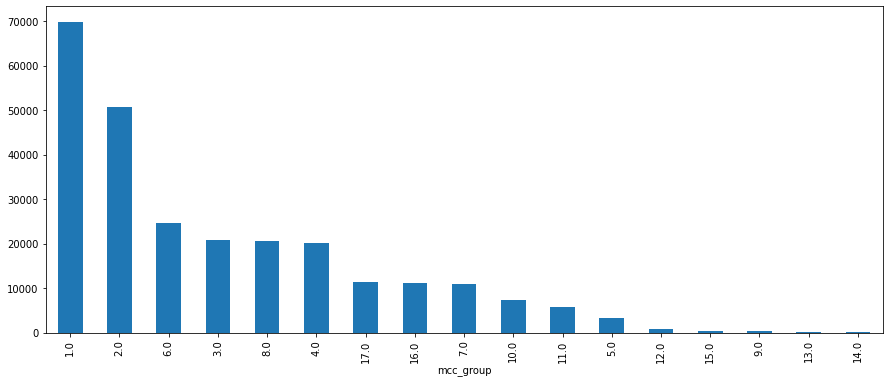

In [51]:
# Distribution of mcc_group before filling NAs

plt.figure(figsize=(15, 6))
data_train.mcc_group.value_counts().plot(kind = 'bar')

In [53]:
data_train.mcc_group.value_counts()

mcc_group
1.0     69807
2.0     50586
6.0     24672
3.0     20875
8.0     20610
4.0     20194
17.0    11466
16.0    11150
7.0     10888
10.0     7282
11.0     5803
5.0      3337
12.0      873
15.0      329
9.0       287
13.0      141
14.0       24
Name: count, dtype: int64

In [52]:
data_train_main_filled.mcc_group.value_counts()

mcc_group
1.0     135865
2.0      86694
6.0      34601
8.0      29771
3.0      26494
4.0      25830
16.0     21238
17.0     13472
7.0      13094
10.0      9543
11.0      6034
5.0       3722
12.0      1355
15.0       345
9.0        295
13.0       163
14.0        30
Name: count, dtype: int64

<Axes: xlabel='mcc_group'>

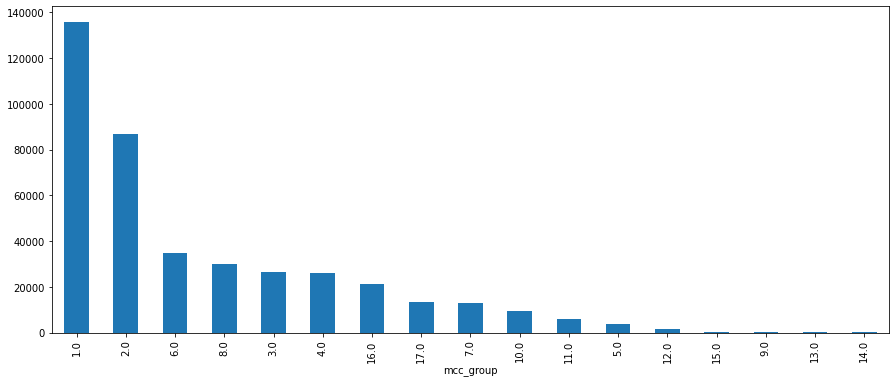

In [47]:
# Distribution of mcc_group after fill

plt.figure(figsize=(15, 6))
data_train_main_filled.mcc_group.value_counts().plot(kind = 'bar')

# checking distribution of response feature

<Axes: xlabel='direction'>

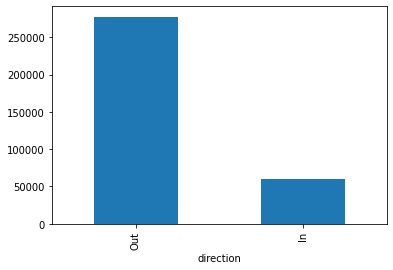

In [26]:
# Distribution of direction
data_train_main_filled.direction.value_counts().plot(kind = 'bar')

The plot shows that the target variable `direction` is imbalanced. With income accounting for 18% and expenses 82%. 

In [27]:
#percentage distribution of direction
data_train_main_filled.direction.value_counts(normalize=True) * 100

direction
Out    82.196647
In     17.803353
Name: proportion, dtype: float64

## Feature engineering

In [ ]:
# encoding categorical columns

categorical_cols = data_train_main_filled.select_dtypes(include = 'object').columns
print(f'categorical_cols:{categorical_cols}')
for col in categorical_cols[1:]:
    data_train_main_filled[col] = LabelEncoder().fit_transform(data_train_main_filled[col])



# set mcc_group into integer

data_train_main_filled['mcc_group'] = data_train_main_filled['mcc_group'].astype(int)

In [ ]:
# A view of the updated data
data_train_main_filled.head()

In [37]:
# Dropping transaction_date, transaction_type, user_id
data_train_main_filled.drop(['user_id', 'transaction_date', 'transaction_type'], axis=1, inplace=True)


In [ ]:
# A quick correlation check
data_train_main_filled.corr()

## splitting

In [41]:
'''
split data
'''
X = data_train_main_filled.drop('direction', axis=1)
y = data_train_main_filled['direction']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


In [ ]:
# Checking the proportion of the classes in the train, validation and test sets
y_train.value_counts(normalize=True) * 100, y_val.value_counts(normalize=True) * 100, y_test.value_counts(normalize=True) * 100

In [45]:
'''
grids search on RF
'''

run_grid_search = False
if run_grid_search:
    
    param_grid = {
        'class_weight': [{0: 1.3, 1: 1.0},{0: 1.4, 1: 1.0}, {0: 1.45, 1: 1.0}, {0: 1.5, 1: 1.0}],
        # 'class_weight': [{0: 2.8, 1: 0.6}, {0: 2.4, 1: 0.6},  {0: 2.2, 1: 0.6}],
        'n_estimators': [50, 100],
        'max_depth': [None, 10, 20],
    }
    

    grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, scoring='roc_auc', cv=3, verbose=3)
   
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_;best_params
    print("Best parameters:", best_params)

# Methods

![title](../img/lr.png)
## 1. LR (logistic regression): 
we use the LR methods as baseline and in addition, we add penalties to the cost function to balance the target variable.

## 2. RF (random forest)

![title](../img/rfTree.png)
`(image source: https://upload.wikimedia.org/wikipedia/commons/4/4e/Random_forest_explain.png)`

In classification problem, the RF method works by constructing multiple decision trees during training and returns the majority vote from these trees.

baseline RF assumes equal importance for all classes, and the weighted approach introduces class weights to modify the splitting criteria of the labels to prioritize minority class.

## 3. MLP (multilayer perceptron)
mlp is a feedforward neural network consisting of fully connected neurons with nonlinear activation functions 





paramter:

- `class_weight`: in the weighted RF, changes to `class_weight` will modify the outcome of the model. after some experiments, the class weight is set as `class_weight={0:1.45, 1:1.0}`
- `max_depth`: the maximum depth of the tree
- `n_estimator`: higher (lower) `n_estimator` could increase (reduce) model accuracy
- weights on LR: to tune the model sensitivity to imbalanced response feature, use `weight_positive=1.` and  `weight_negative=1.45`. these values are thesame as in `class_weight`
- `hidden_layer_sizes`: The ith element represents the number of neurons in the ith hidden layer.
- `activation`: activation function for the hidden layer. other options are {identity, logistic, tanh}.
- `solver`: the solver for weight optimization. other options to try are `lbfgs` and `sgd`.

In [ ]:
'''
train model
'''

n_estimator = 100
seedS = 42
lr = 0.01
max_iter = 1000
max_depth = 15

models = {
    "Baseline RF": RandomForestClassifier(n_estimators=n_estimator, random_state=seedS),
    "Weighted RF": RandomForestClassifier(n_estimators=n_estimator, class_weight={0:1.45, 1:1.0}, max_depth=max_depth, random_state=seedS),
    "Baseline LR": LogisticRegressionModels(model_type="baseline", learning_rate=lr, max_iter=max_iter),
    "cost LR": LogisticRegressionModels(model_type="cost_sensitive", weight_positive=1., weight_negative=1.45, learning_rate=lr, max_iter=max_iter),
    "MLP": MLPClassifier(hidden_layer_sizes=(50,), activation='relu', solver='adam', verbose=False,learning_rate_init=lr, max_iter=max_iter, random_state=seedS),
} #relu

results = {}
for name, model in models.items():
    print(f"Training {name}")
    if model.__class__.__name__ in ['RandomForestClassifier', 'MLPClassifier']:
        model.fit(X_train, y_train)
    elif model.__class__.__name__ == 'LogisticRegressionModels':
        model.fit(X_train, y_train, X_val, y_val)
    else:
        raise ValueError("Model not supported")
        
    show_curves = False
    if show_curves:
        if isinstance(model, (LogisticRegressionModels)):  
            plt.figure(figsize=(10, 6))
            plt.plot(model.train_losses, label='Training Loss')
            plt.plot(model.val_losses, label='Validation Loss')
            plt.xlabel('Iteration')
            plt.ylabel('Loss')
            plt.title(f'{name} Training and Validation Loss Curves')
            plt.legend()
            plt.grid()
            plt.show()

    # pred
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)
    y_pred_test = model.predict(X_test)
    

    # metric
    train_accuracy = accuracy_score(y_train, y_pred_train)
    val_accuracy = accuracy_score(y_val, y_pred_val)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    f1 = f1_score(y_test, y_pred_test)
    
    if model.__class__.__name__ in ['RandomForestClassifier', 'MLPClassifier']:
        y_pred_proba_test = model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_pred_proba_test)
    elif model.__class__.__name__ == 'LogisticRegressionModels':
        y_pred_proba_test = model.predict_proba(X_test)
        auc = roc_auc_score(y_test, y_pred_proba_test)

    # Save model
     # joblib.dump(model, f"models/{name.replace(' ', '_')}_model.pkl")
    
    results[name] = {
        "Train Accuracy": train_accuracy,
        "Val Accuracy": val_accuracy,
        "Test Accuracy": test_accuracy,
        "AUC": auc,
        "f1": f1,
        "Model": model,
        }
    print(f"--- {name} saved ---")
    print(f"Train Accuracy: {train_accuracy:.2f}")
    print(f"Val Accuracy: {val_accuracy:.2f}")
    print(f"Test Accuracy: {test_accuracy:.2f}")

In [ ]:
#Check test accuracy
methods = list(results.keys())
test_accuracies_ = [metrics['Test Accuracy'] for metrics in results.values()]

list(zip(methods,test_accuracies_))

In [ ]:
'''
plot accuraries
'''

labels = list(results.keys())
train_accuracies = [metrics['Train Accuracy'] for metrics in results.values()]
val_accuracies = [metrics['Val Accuracy'] for metrics in results.values()]
test_accuracies = [metrics['Test Accuracy'] for metrics in results.values()]

bar_width = 0.2
indices = np.arange(len(labels))
figsize = (16, 8)
plotter.plot_barplot( indices, train_accuracies, val_accuracies, test_accuracies, labels, bar_width=bar_width, figsize=figsize)


In [ ]:
# Check the F1 score
f1_ = [metrics['f1'] for metrics in results.values()]

list(zip(methods,f1_))

In [ ]:
'''
plot AUC curves
'''
from sklearn.metrics import roc_curve

def plot_auc_curves(results, X_test, y_test, figsize=(10, 6)):
    """
    ROC curves here.
    """
    plt.figure(figsize=figsize)
    for name, metrics in results.items():
        model = metrics["Model"]
        if model.__class__.__name__ in ['RandomForestClassifier', 'MLPClassifier']:
            y_pred_proba_test = model.predict_proba(X_test)[:, 1]
            fpr, tpr, _ = roc_curve(y_test, y_pred_proba_test)
        elif model.__class__.__name__ == 'LogisticRegressionModels':
            y_pred_proba_test = model.predict_proba(X_test)
            fpr, tpr, _ = roc_curve(y_test, y_pred_proba_test)
        else:
            continue 
        
        plt.plot(fpr, tpr, label=f'{name} (AUC = {metrics["AUC"]:.2f})')
    plt.plot([0, 1], [0, 1], "k--", label="Random Guessing")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="best", fontsize=20)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

figsize=(12, 8)
plotter.plot_auc_curves(results, X_test, y_test, figsize=figsize)

## Test case

In [11]:
import importlib
from preprocessing import load_and_preprocess
import preprocessing2 #import load_and_preprocessT

# lets compare `July_data` with `predict_df`

In [ ]:
#Predicted Data
output_csv_path = "./result/predictions_all_models.csv"
prediction_df_ = pd.read_csv(output_csv_path)
prediction_df_.head()

In [ ]:
importlib.reload(preprocessing2)

In [ ]:
# July data
new_data_dir = "../data/2016-09-19_79351_training_july.csv" 
new_data = preprocessing2.load_and_preprocessT(new_data_dir, training=False)

new_data.head(2)